In [1]:
import pandas as pd

from sklearn import preprocessing, compose, pipeline
from sklearn import linear_model # LogisticRegression
from sklearn import svm

from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

In [2]:
df = pd.read_csv("train.csv")
df.sample(5)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
179248,298928,A,B,A,C,B,C,A,E,G,...,0.911438,0.424840,0.241187,0.849827,0.806916,0.549276,0.777521,0.907828,0.297939,8.756218
40756,67679,A,A,A,C,B,B,A,E,C,...,0.272124,0.282931,0.265756,0.481961,0.300509,0.394259,0.328607,0.430818,0.297132,6.167811
23671,39391,A,A,A,A,B,B,A,E,C,...,0.382949,0.403269,0.527175,0.374205,0.407399,0.354803,0.287555,0.319031,0.383421,8.002176
119389,198973,A,B,A,A,B,B,A,E,C,...,0.349340,0.376311,0.331963,0.407182,0.459181,0.504035,0.389042,0.365141,0.640940,7.681335
211461,352640,A,B,A,C,B,B,A,E,F,...,0.443239,0.950373,0.349333,0.485012,0.577155,0.622252,0.413454,0.352188,0.377585,8.840490


In [3]:
df = df.sample(1000)

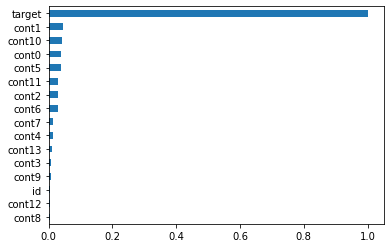

In [4]:
df.corr()["target"].abs().sort_values().plot.barh();

In [5]:
cont_features = [f for f in df.columns.tolist() if f.startswith('cont')]
cat_features  = [f for f in df.columns.tolist() if f.startswith('cat')]

# Create linear model

In [6]:
num_preprocessing = pipeline.Pipeline(steps=[
    ('scaler', preprocessing.StandardScaler())
])

cat_preporcessing = pipeline.Pipeline(steps=[
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, cont_features),
    ('cat', cat_preporcessing, cat_features),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars


model = linear_model.LinearRegression()

pipe = pipeline.Pipeline(steps=[('prepro', prepro), ('model', model)])

pipe

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['cont0', 'cont1', 'cont2',
                                                   'cont3', 'cont4', 'cont5',
                                                   'cont6', 'cont7', 'cont8',
                                                   'cont9', 'cont10', 'cont11',
                                                   'cont12', 'cont13']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat4', 'cat5',
                                                   'cat6', 'cat7', 'cat8',
                                                   'cat9'])])),
                ('model', LinearRegression())])

# Train linear model

In [7]:
x = df[cont_features + cat_features ]
y = df["target"]

pipe.fit(x, y)

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['cont0', 'cont1', 'cont2',
                                                   'cont3', 'cont4', 'cont5',
                                                   'cont6', 'cont7', 'cont8',
                                                   'cont9', 'cont10', 'cont11',
                                                   'cont12', 'cont13']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat4', 'cat5',
                                                   'cat6', 'cat7', 'cat8',
                                                   'cat9'])])),
                ('model', LinearRegression())])

# OPTUNA + VAL STRATEGY CV?

In [8]:
import optuna
optuna.__version__

'2.7.0'

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict


In [16]:
def objective(trial):
    
    ################################# 1. OPTUNA will select the hparams
    c       = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
    kernel  = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    epsilon = trial.suggest_uniform('epsilon', 0, 1.0) # suggest_float
    
    #suggest_int, suggest_discrete_uniform
    
    ################################# 2. with those hparams --> We create the model
    
    print("TRIAL with", c, kernel, epsilon)
    #model = svm.SVR(C=c, kernel='linear')
    
    model = linear_model.LinearRegression()
    
    pipe = pipeline.Pipeline(steps=[('prepro', prepro), ('model', model)])
    
    
    ################################# 3. OPTIAN A: Train & Validate the model (SIMPLE SPLIT)
    
    pipe.fit(x_train, y_train)    
    pred = pipe.predict(x_test)
    valition_rmse = mean_squared_error(y_test, pred) 
    
    ################################# 3. OPTIAN B: Train & Validate the model (CrossVal)
    
    oof_preds = cross_val_predict(pipe, x, y, cv=5)
    valition_rmse = mean_squared_error(y, oof_preds)

    
    
    return valition_rmse

In [13]:
#study = optuna.create_study(direction='minimize', sampler = optuna.samplers.GridSampler()) 
#study = optuna.create_study(direction='minimize', sampler = optuna.samplers.RandomSampler()) 
#study = optuna.create_study(direction='minimize', sampler = optuna.samplers.CmaEsSampler() )
#study = optuna.create_study(direction='minimize', sampler = optuna.samplers.TPESampler(multivariate = False)) 
#study = optuna.create_study(direction='minimize', sampler = optuna.samplers.TPESampler(multivariate = True)) 
study = optuna.create_study(direction='minimize') 

study.optimize(objective, n_trials=300) # Recommend: 100, 200

[I 2021-05-11 11:10:16,195] A new study created in memory with name: no-name-c94d4ad0-dd6c-4780-a030-cec1754ac29a
[I 2021-05-11 11:10:16,234] Trial 0 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 57456111.418364614, 'kernel': 'rbf', 'epsilon': 0.27744331829394997}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,254] Trial 1 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 4.680639511580288e-06, 'kernel': 'rbf', 'epsilon': 0.9429449923052885}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,273] Trial 2 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 0.00042266000108055415, 'kernel': 'rbf', 'epsilon': 0.6119575296904742}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,294] Trial 3 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 1.695331143172685e-08, 'kernel': 'poly', 'epsilon': 0.5567844011985708}. Best is trial 0 with valu

TRIAL with 57456111.418364614 rbf 0.27744331829394997
TRIAL with 4.680639511580288e-06 rbf 0.9429449923052885
TRIAL with 0.00042266000108055415 rbf 0.6119575296904742
TRIAL with 1.695331143172685e-08 poly 0.5567844011985708
TRIAL with 8393800.358176459 poly 0.48730777278978366
TRIAL with 9864425.504396463 sigmoid 0.7760056804905007
TRIAL with 0.012058210816172145 rbf 0.9774710697192015
TRIAL with 6442930937.534517 linear 0.5004433925202443
TRIAL with 607322.033838991 poly 0.7317135604858
TRIAL with 332.32328996712994 linear 0.621512118325667


[I 2021-05-11 11:10:16,408] Trial 9 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 332.32328996712994, 'kernel': 'linear', 'epsilon': 0.621512118325667}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,431] Trial 10 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 92.51738946064073, 'kernel': 'rbf', 'epsilon': 0.15658743791068863}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,455] Trial 11 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 1.680083238384529e-09, 'kernel': 'rbf', 'epsilon': 0.20961936020145555}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,475] Trial 12 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 6.263413183923478e-06, 'kernel': 'rbf', 'epsilon': 0.28592259226714223}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,497] Trial 13 finished with value: 2.005807318771757e+21 and par

TRIAL with 92.51738946064073 rbf 0.15658743791068863
TRIAL with 1.680083238384529e-09 rbf 0.20961936020145555
TRIAL with 6.263413183923478e-06 rbf 0.28592259226714223
TRIAL with 8.409984827173669e-07 rbf 0.006536140688714498
TRIAL with 1.335399340387808 sigmoid 0.35659997298693547
TRIAL with 0.0031132557924434968 rbf 0.9366735747001083
TRIAL with 2670979436.22605 rbf 0.029715520607979218
TRIAL with 4188.624813873711 sigmoid 0.36383572975747397
TRIAL with 0.08266748813576894 rbf 0.875170494549407


[I 2021-05-11 11:10:16,636] Trial 19 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 4007317244.003479, 'kernel': 'linear', 'epsilon': 0.027783601462732677}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,661] Trial 20 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 6182.309728423473, 'kernel': 'sigmoid', 'epsilon': 0.37427953120613433}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,684] Trial 21 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 1.5699988700183163, 'kernel': 'sigmoid', 'epsilon': 0.1451570156705934}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,705] Trial 22 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 363495653.57007843, 'kernel': 'linear', 'epsilon': 0.07065649287198847}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,729] Trial 23 finished with value: 2.005807318771757e+21 

TRIAL with 4007317244.003479 linear 0.027783601462732677
TRIAL with 6182.309728423473 sigmoid 0.37427953120613433
TRIAL with 1.5699988700183163 sigmoid 0.1451570156705934
TRIAL with 363495653.57007843 linear 0.07065649287198847
TRIAL with 103764.8145031247 linear 0.39124805027928405
TRIAL with 10.665108549562321 sigmoid 0.1562006485314677
TRIAL with 52304204.57050433 linear 0.09610771217543304
TRIAL with 176779.12902685328 linear 0.2582434688566084
TRIAL with 146100.9042577841 sigmoid 0.42023846488417144


[I 2021-05-11 11:10:16,842] Trial 28 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 48985395.276989006, 'kernel': 'linear', 'epsilon': 0.14426275995834797}. Best is trial 0 with value: 2.005807318771757e+21.
[I 2021-05-11 11:10:16,866] Trial 29 finished with value: 2.005807318771757e+21 and parameters: {'svc_c': 86426532.74424317, 'kernel': 'linear', 'epsilon': 0.27308455686440786}. Best is trial 0 with value: 2.005807318771757e+21.


TRIAL with 48985395.276989006 linear 0.14426275995834797
TRIAL with 86426532.74424317 linear 0.27308455686440786


# TRAIN AGIAN WITH THE BERST HPARAMS FOUND BY OPUTNA

In [14]:
study.best_params

{'svc_c': 57456111.418364614, 'kernel': 'rbf', 'epsilon': 0.27744331829394997}

In [ ]:

new_model = model(**study.best_params)

# See coefficients

In [11]:
cat_onehot_features = pipe["prepro"].named_transformers_["cat"]['onehot'].get_feature_names(cat_features).tolist()

all_features = cont_features + cat_onehot_features
len(all_features)

70

In [13]:
coefs = pipe["model"].coef_.tolist()

In [14]:
coefs_df = pd.DataFrame(data=coefs, index=all_features, columns=["Coefs"])
coefs_df

,Coefs
cont0,-5.863777e-02
cont1,3.628011e-02
cont2,1.773693e-03
cont3,-5.698778e-03
cont4,-5.333955e-03
...,...
cat9_K,-8.281560e+10
cat9_L,-8.281560e+10
cat9_M,-8.281560e+10
cat9_N,-8.281560e+10


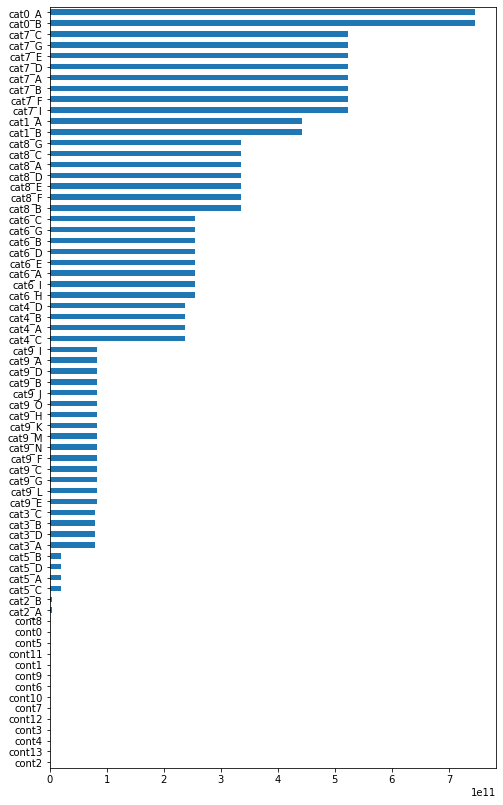

In [15]:
coefs_df["Coefs"].abs().sort_values().plot.barh(figsize=(8,14));

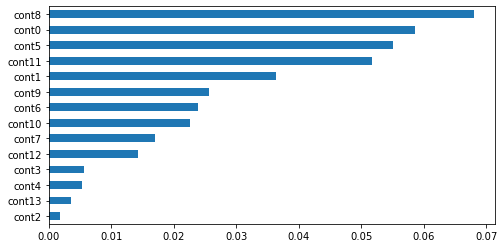

In [16]:
coefs_df.head(14)["Coefs"].abs().sort_values().plot.barh(figsize=(8,4));